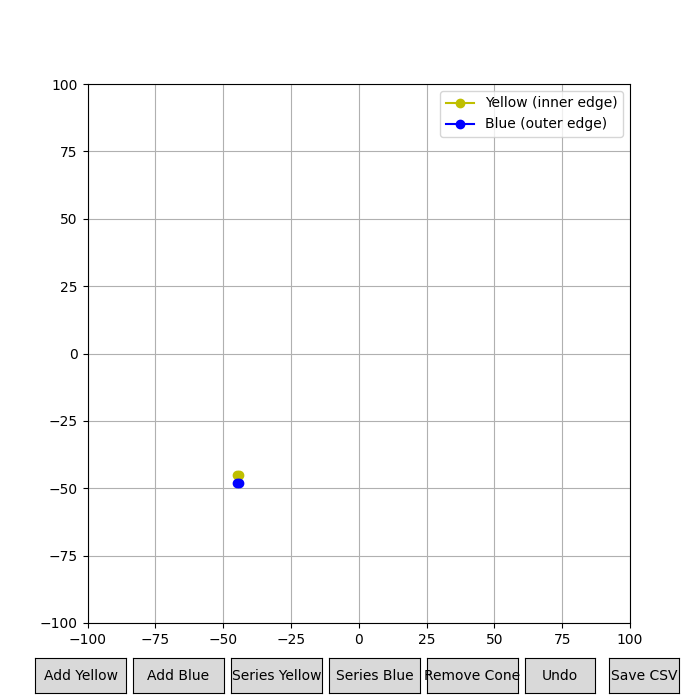

In [ ]:
# === TRACK GENERATOR (v4.0) ===
# Tryb "celownika" + usuwanie + add-in-series
# Autor: TymekProstak + GPT-5

%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import pandas as pd
import math
import tkinter as tk
from tkinter import simpledialog, messagebox

plt.ion()

# === GUI ===
root = tk.Tk()
root.withdraw()
root.attributes('-topmost', True)
root.lift()

# === MAP SETTINGS ===
map_width = float(simpledialog.askstring("Mapa", "Podaj szerokość mapy [m]:"))
map_height = float(simpledialog.askstring("Mapa", "Podaj wysokość mapy [m]:"))

yellow_points = []
blue_points = []
lane_width = 3.0
click_cid = None
move_cid = None
crosshair_lines = []
series_mode = None  # 'yellow' lub 'blue'
remove_mode = False

# === START: 2 żółte + 2 niebieskie ===
x1 = -map_width / 2 + 5
y1 = -map_height / 2 + 5
x2 = x1 + 1.0
y2 = y1
yellow_points.extend([(x1, y1), (x2, y2)])

dx, dy = x2 - x1, y2 - y1
L = math.hypot(dx, dy)
nx, ny = -dy / L, dx / L
b1 = (x1 + nx * lane_width, y1 - ny * lane_width)
b2 = (x2 + nx * lane_width, y2 - ny * lane_width)
blue_points.extend([b1, b2])

# === FIGURE ===
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(-map_width , map_width )
ax.set_ylim(-map_height , map_height )
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_title("Track Generator — ready")
ax.grid(True)

# === DRAW ===
def plot_points():
    ax.clear()
    ax.set_xlim(-map_width , map_width )
    ax.set_ylim(-map_height , map_height )
    ax.grid(True)
    if yellow_points:
        ax.plot(*zip(*yellow_points), 'yo-', label='Yellow (inner edge)')
    if blue_points:
        ax.plot(*zip(*blue_points), 'bo-', label='Blue (outer edge)')
    if yellow_points or blue_points:
        ax.legend()
    plt.draw()

def show_crosshair(event):
    """Rysuje krzyżyk na pozycji kursora i pokazuje współrzędne."""
    if event.xdata is None or event.ydata is None:
        return
    x, y = event.xdata, event.ydata
    global crosshair_lines
    for line in crosshair_lines:
        line.remove()
    crosshair_lines = []
    crosshair_lines.append(ax.axhline(y, color='red', linestyle='--', linewidth=0.7))
    crosshair_lines.append(ax.axvline(x, color='red', linestyle='--', linewidth=0.7))
    ax.set_title(f"Track Generator — aiming: x={x:.2f}, y={y:.2f}")
    plt.draw()

def clear_crosshair():
    global crosshair_lines
    for line in crosshair_lines:
        try:
            line.remove()
        except:
            pass
    crosshair_lines = []
    plt.draw()

# === CLICK HANDLERS ===
def onclick_yellow(event):
    if event.xdata is None or event.ydata is None:
        return
    yellow_points.append((event.xdata, event.ydata))
    plot_points()
    stop_click_mode()
    handle_blue_prompt()

def onclick_blue(event):
    if event.xdata is None or event.ydata is None:
        return
    blue_points.append((event.xdata, event.ydata))
    plot_points()
    stop_click_mode()

def onclick_remove(event):
    """Usuwanie najbliższego pachołka po kliknięciu."""
    if event.xdata is None or event.ydata is None:
        return
    x, y = event.xdata, event.ydata

    def closest_point(points):
        if not points:
            return None, None
        dists = [(i, math.hypot(px - x, py - y)) for i, (px, py) in enumerate(points)]
        idx, dist = min(dists, key=lambda t: t[1])
        return idx, dist

    yi, yd = closest_point(yellow_points)
    bi, bd = closest_point(blue_points)
    if yd is None and bd is None:
        return
    if bd is None or (yd is not None and yd < bd):
        yellow_points.pop(yi)
    else:
        blue_points.pop(bi)
    plot_points()

def onclick_series(event):
    """Dodawanie wielu pachołków w serii."""
    global series_mode
    if series_mode is None or event.button == 3:
        stop_click_mode()
        return
    if event.xdata is None or event.ydata is None:
        return
    if series_mode == "yellow":
        yellow_points.append((event.xdata, event.ydata))
    elif series_mode == "blue":
        blue_points.append((event.xdata, event.ydata))
    plot_points()

# === CLICK MODE ===
def start_click_mode(color):
    global click_cid, move_cid
    stop_click_mode()
    ax.set_title(f"Track Generator — current mode: {color}-click")
    plt.draw()
    move_cid = fig.canvas.mpl_connect("motion_notify_event", show_crosshair)
    if color == "yellow":
        click_cid = fig.canvas.mpl_connect("button_press_event", onclick_yellow)
    elif color == "blue":
        click_cid = fig.canvas.mpl_connect("button_press_event", onclick_blue)

def stop_click_mode():
    global click_cid, move_cid, series_mode, remove_mode
    if click_cid:
        fig.canvas.mpl_disconnect(click_cid)
        click_cid = None
    if move_cid:
        fig.canvas.mpl_disconnect(move_cid)
        move_cid = None
    series_mode = None
    remove_mode = False
    clear_crosshair()
    ax.set_title("Track Generator — ready")
    plt.draw()

# === SERIES MODE ===
def start_series_mode(color):
    global series_mode, click_cid, move_cid
    stop_click_mode()
    series_mode = color
    ax.set_title(f"Track Generator — series mode: {color} (right click = stop)")
    move_cid = fig.canvas.mpl_connect("motion_notify_event", show_crosshair)
    click_cid = fig.canvas.mpl_connect("button_press_event", onclick_series)
    plt.draw()

# === REMOVE MODE ===
def start_remove_mode():
    global remove_mode, click_cid, move_cid
    stop_click_mode()
    remove_mode = True
    ax.set_title("Track Generator — remove mode (click cone to delete)")
    move_cid = fig.canvas.mpl_connect("motion_notify_event", show_crosshair)
    click_cid = fig.canvas.mpl_connect("button_press_event", onclick_remove)
    plt.draw()

# === ADDING ===
def ask_mode(color):
    choice = simpledialog.askstring(
        f"Dodaj {color}",
        f"Jak chcesz dodać {color} punkt?\nWpisz: manual / click"
    )
    return choice.lower().strip() if choice else None

def add_yellow():
    mode = ask_mode("yellow")
    if not mode:
        return
    if mode == "manual":
        coords = simpledialog.askstring("Dodaj yellow", "Podaj X,Y:")
        if not coords:
            return
        x, y = map(float, coords.split(","))
        yellow_points.append((x, y))
        plot_points()
        handle_blue_prompt()
    elif mode == "click":
        start_click_mode("yellow")

def add_blue():
    mode = ask_mode("blue")
    if not mode:
        return
    if mode == "manual":
        coords = simpledialog.askstring("Dodaj blue", "Podaj X,Y:")
        if not coords:
            return
        x, y = map(float, coords.split(","))
        blue_points.append((x, y))
        plot_points()
    elif mode == "click":
        start_click_mode("blue")

def handle_blue_prompt():
    global lane_width
    choice = simpledialog.askstring(
        "Niebieski punkt",
        "Co chcesz zrobić z niebieskim punktem?\n(auto / manual / skip)"
    )
    if not choice:
        return
    choice = choice.lower().strip()
    if choice == "auto":
        w_str = simpledialog.askstring("Szerokość toru", f"Szerokość [m] (obecnie {lane_width}):")
        if w_str:
            lane_width = float(w_str)
        if len(yellow_points) >= 2:
            x1, y1 = yellow_points[-2]
            x2, y2 = yellow_points[-1]
        else:
            x2, y2 = yellow_points[-1]
            x1, y1 = x2 - 1, y2
        dx, dy = x2 - x1, y2 - y1
        L = math.hypot(dx, dy)
        nx, ny = -dy / L, dx / L
        bx = x2 + nx * lane_width
        by = y2 - ny * lane_width
        blue_points.append((bx, by))
        plot_points()
    elif choice == "manual":
        add_blue()

# === UNDO / SAVE ===
def undo():
    if not yellow_points and not blue_points:
        return
    if yellow_points and (len(yellow_points) >= len(blue_points)):
        yellow_points.pop()
    elif blue_points:
        blue_points.pop()
    plot_points()

def save_csv():
    data = []
    for (x, y) in yellow_points:
        data.append((x, y, "yellow"))
    for (x, y) in blue_points:
        data.append((x, y, "blue"))
    df = pd.DataFrame(data, columns=["X", "Y", "Type"])
    df.to_csv("track.csv", index=False)
    messagebox.showinfo("Zapisano", "Zapisano track.csv!")

# === BUTTONS ===
ax_y = plt.axes([0.05, 0.01, 0.13, 0.05])
ax_b = plt.axes([0.19, 0.01, 0.13, 0.05])
ax_sy = plt.axes([0.33, 0.01, 0.13, 0.05])
ax_sb = plt.axes([0.47, 0.01, 0.13, 0.05])
ax_r = plt.axes([0.61, 0.01, 0.13, 0.05])
ax_u = plt.axes([0.75, 0.01, 0.10, 0.05])
ax_s = plt.axes([0.87, 0.01, 0.10, 0.05])

btn_y = Button(ax_y, "Add Yellow")
btn_b = Button(ax_b, "Add Blue")
btn_sy = Button(ax_sy, "Series Yellow")
btn_sb = Button(ax_sb, "Series Blue")
btn_r = Button(ax_r, "Remove Cone")
btn_u = Button(ax_u, "Undo")
btn_s = Button(ax_s, "Save CSV")

btn_y.on_clicked(lambda e: add_yellow())
btn_b.on_clicked(lambda e: add_blue())
btn_sy.on_clicked(lambda e: start_series_mode("yellow"))
btn_sb.on_clicked(lambda e: start_series_mode("blue"))
btn_r.on_clicked(lambda e: start_remove_mode())
btn_u.on_clicked(lambda e: undo())
btn_s.on_clicked(lambda e: save_csv())

plot_points()
plt.show()
